# Solving the Boltzman equation for DM Freeze-In

## Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpmath 

## Usefull constants

In [3]:
mnu=0.0
pi=np.pi
G = 6.71*10**-45 # MeV
Mpl = (8 * pi * G) ** (-0.5)
yinf=4.35*10**-7 # Divided by the mass of the particle
y0=0.0
geff=3

## Import $g_{*s}$

In [4]:
data = np.loadtxt('g_*s(T).txt', skiprows=1)
t_imported = data[:, 0]
g_star_s_imported = data[:, 1]
def g_star_s_interp_func(t):
    return sp.interpolate.interp1d(t_imported, g_star_s_imported, fill_value="extrapolate")(t)


## Math functions

In [5]:
def bk(n,x):
    return sp.special.kn(n,x)

def gmeijer1(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [1]], [[-1/2, -1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

def gmeijer2(x):
    x_mpf = mpmath.mpf(x)
    try:
        return float(mpmath.meijerg([[], [2]], [[-1/2, 1/2, 1/2], []], x_mpf**2))
    except (ValueError, mpmath.libmp.libhyper.HypercombError):
        return 0.0 

## Number density of massive fermions

In [6]:
def int_n_e(E, m, T):
    arg = E / T
    arg = np.clip(arg, None, 700)  # Avoid overflow in exp
    return E * np.sqrt(E**2 - m**2) / (np.exp(arg) + 1)

def n_e(m,T,glib):
    int=[]
    if m>0:
        int.append(sp.integrate.quad(int_n_e,m,m*10,args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,m*10**(i+1),m*10**(i+2),args=(m,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    elif m==0:
        int.append(sp.integrate.quad(int_n_e,0,1,args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        for i in range(10):
            int.append(sp.integrate.quad(int_n_e,10**i,10**(i+1),args=(0,T),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
        int1=np.sum(int)
        return (glib/(2*np.pi**2))*int1
    else:
        print('Error: Negative mass')
        return 0
    

## Thermodinamical properties of "massless" fermions

In [7]:
def n_nu(T,glib):                                              # If Dirac fermions glib=4
    return 3*glib*sp.special.zeta(3)*T**3/(4*np.pi**2)         # If Majorana fermions glib=2 

def rho_nu(T,glib):                                                 # If Dirac fermions glib=4
    return (7*glib*np.pi**2*T**4)/(240)                        # If Majorana fermions glib=2 

def p_nu(T,glib):
    return (1/3)*rho_nu(T,glib)

def s_nu(T,glib):
    return (4*rho_nu(T,glib))/(3*T)

def Y_nu(T,glib):
    return n_nu(T,glib)/s_nu(T,glib)    

## Neutrino functions

$$ \sigma=\frac{g^2}{32\pi s^2}\sqrt{\frac{s-4m_\chi^2}{s}}\left[s+\frac{(s-4m_\chi^2)}{3}+4m_\chi^2    \right]$$

$$<\sigma v>=\frac{1}{8 m_\chi^4 T K_2^2(m_\chi/T)}\int_{4m_\chi^2}^\infty ds\; \sigma(s-4m_\chi^2)\sqrt{s}K_1(\sqrt{s}/T) $$

$$<\sigma v>=\frac{g^2}{192 \pi m^3 K_2^2(x)}\left\{4 m_\chi K_1^2(x)-\sqrt{\pi}m_\chi x\left[ 

G_1(x^2)+G_2(x^2)
\right]
\right\} $$

$$ \frac{dY_\nu}{dx}=\frac{2<\sigma v>_\nu n_\nu^2}{xHs}$$

In [8]:
def sigma_nu(s,g,mchi):
    a1=g**2/(32*pi*s**2)
    a2=np.sqrt((s-4*mchi**2)/(s))
    a3=(s+(s-4*mchi**2)/(3)+4*mchi**2)
    return a1*a2*a3

def intsigma_nu(s,g,mchi,T):
    a1=sigma_nu(s,g,mchi)
    a2=(s-4*mchi**2)
    a3=np.sqrt(s)
    a4=bk(1,np.sqrt(s)/T)
    return a1*a2*a3*a4

def sigmav_nu_num(g,mchi,x):
    int=[]
    n=50
    for i in range(n):
        int.append(sp.integrate.quad(intsigma_nu,2**(2*i+2)*mchi**2,2**(2*i+4)*mchi**2,args=(g,mchi,mchi/x),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int.append(sp.integrate.quad(intsigma_nu,2**(2*n+3)*mchi**2,np.inf,args=(g,mchi,mchi/x),epsabs=1e-10,epsrel=1e-10,limit=1000)[0])
    int2=np.sum(int)
    if int2==0.0:
        #print("Warning: sigmav_e is zero, returning 0")
        return 0.0
    a1=x/(8*mchi**5*bk(2,x)**2)
    return a1*(int2)

def dYdx_nu_num(y,x,g,mchi):
    a1=sigmav_nu_num(g,mchi,x)
    a2=n_nu(mchi/x,2)
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

In [9]:
# physical constant: final (instantaneous-decoupling) ratio
TNU_OVER_TGAMMA_infty = (4.0/11.0)**(1.0/3.0)  # ~0.713766

def Tnu_over_Tgamma_approx(T_gamma_MeV, Tdec=0.511, width=0.6):
    x = np.array(T_gamma_MeV, dtype=float)
    s = np.tanh((x - Tdec) / width)  
    r = 0.5*(1.0 + s) * 1.0 + 0.5*(1.0 - s) * TNU_OVER_TGAMMA_infty
    return r

def Tnu_from_Tgamma(T_gamma_MeV, **kwargs):
    return Tnu_over_Tgamma_approx(T_gamma_MeV, **kwargs) * np.array(T_gamma_MeV, dtype=float)

In [10]:
def sigmav_nu(g,mchi,x):
    a1=g**2/(192*pi*mchi**3*bk(2,x)**2)
    a21=4*mchi*bk(1,x)**2
    a22=np.sqrt(pi)*mchi*x*(gmeijer1(x)+gmeijer2(x))
    return a1*(a21-a22)

def dYdx_nu(y,x,g,mchi):
    T= mchi/x
    T_nu = Tnu_from_Tgamma(T)               # We change the temperature to T_nu for the yield computations but not the evolution of the universe
    x_nu = mchi/T_nu  
    a1=sigmav_nu(g,mchi,x_nu)
    a2=n_nu(mchi/x_nu,6)               # glib=6 for 3 neutrino species
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

def dYdx_nu_mod(y,x,g,mchi):
    a1=sigmav_nu(g,mchi,x)
    a2=n_nu(mchi/x,6)               # glib=6 for 3 neutrino species
    a3=((2*pi**2)/45)*(mchi/x)**3*g_star_s_interp_func(mchi/x)
    a4=(pi*(mchi/x)**2)*np.sqrt(g_star_s_interp_func(mchi/x)/90)/Mpl
    return 2*a1*a2**2/(x*a3*a4)

In [11]:
mchi=[0.01,0.1,1,10,100]
x=np.logspace(-8,2,5000)
g_nu=[8.170941213343994e-13,
      9.567941012596983e-13,
      9.752393384053349e-13,
      9.286370073035458e-13,
      1.3203367344719753e-12]  # Example values for g_nu, can be modified as needed
yplot_nu1=[]
yplot_nu=[]
#yplot2=[]
#yplot3=[]
for i in range(len(mchi)):
    #y_nu1=sp.integrate.odeint(dYdx_nu,y0,x,args=(g_nu,mchi[i]),rtol=1e-12, atol=1e-12, mxstep=10000)
    y_nu=sp.integrate.odeint(dYdx_nu,y0,x,args=(g_nu[i],mchi[i]),rtol=1e-12, atol=1e-12, mxstep=10000)
    #yplot_nu1.append(y_nu1)
    yplot_nu.append(y_nu)
    print("Process is at ", i+1, " of ", len(mchi))

Process is at  1  of  5
Process is at  2  of  5
Process is at  3  of  5
Process is at  4  of  5
Process is at  5  of  5


In [12]:
for i in range(len(mchi)):
    print("----------------------------------------------------------")
    print("m_chi=",mchi[i],"MeV")
    print("g_nu= ",g_nu[i])
    print("Final yield for neutrinos = ",yplot_nu[i][-1])
    print(yplot_nu[i][-1]/(yinf/mchi[i]))
    print("----------------------------------------------------------")

----------------------------------------------------------
m_chi= 0.01 MeV
g_nu=  8.170941213343994e-13
Final yield for neutrinos =  [4.29605705e-05]
[0.98759932]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 0.1 MeV
g_nu=  9.567941012596983e-13
Final yield for neutrinos =  [4.30633157e-06]
[0.98996128]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 1 MeV
g_nu=  9.752393384053349e-13
Final yield for neutrinos =  [4.26756563e-07]
[0.98104957]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 10 MeV
g_nu=  9.286370073035458e-13
Final yield for neutrinos =  [4.32913711e-08]
[0.99520393]
----------------------------------------------------------
----------------------------------------------------------
m_chi= 100 MeV
g_nu=  1.3203367344719753e-12
Final yield fo

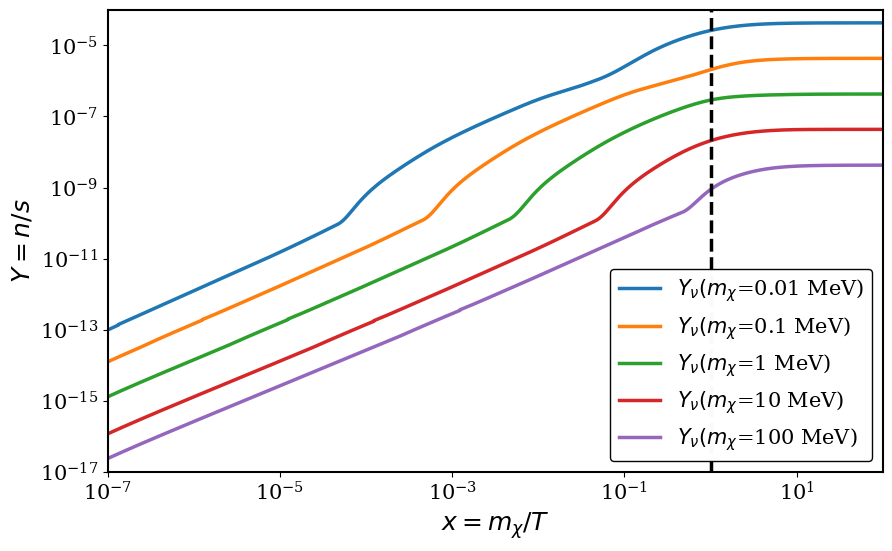

In [16]:
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 16,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "axes.linewidth": 1.5,
    "lines.linewidth": 2.5,
    "legend.frameon": True,
    "legend.framealpha": 0.98,
    "legend.fancybox": True,
    "legend.edgecolor": "black",
    "text.usetex": False,
})


plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})
color=plt.cm.rainbow(np.linspace(0,1,len(mchi)))
for i in range(len(mchi)):
    # To plot vs temperature in MeV simply change x for mchi[i]/x
    plt.plot(x,yplot_nu[i],label=fr'$Y_\nu(m_\chi$={mchi[i]} MeV)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(fr'$x=m_\chi/T$')
plt.ylabel(fr'$Y=n/s$')
plt.axvline(x=1, color='black', linestyle='--')
plt.xlim(1e-7, 1e2)
plt.ylim(1e-17, 1e-4)
plt.legend()
plt.show()


# the suddent bump in the yield is due to the change in the temperature of the neutrinos, which is not accounted for in the usual yield computation.